##CNN Example:
cat & dog


In [18]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd


In [4]:
!!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

['--2024-04-13 20:37:20--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
 'Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 142.250.98.207, 142.250.97.207, ...',
 'Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 68606236 (65M) [application/zip]',
 'Saving to: ‘cats_and_dogs_filtered.zip’',
 '',
 '',
 '          cats_and_   0%[                    ]       0  --.-KB/s               ',
 '         cats_and_d  24%[===>                ]  16.35M  80.4MB/s               ',
 '        cats_and_do  71%[=============>      ]  46.61M   116MB/s               ',
 'cats_and_dogs_filte 100%[===================>]  65.43M   127MB/s    in 0.5s    ',
 '',
 '2024-04-13 20:37:20 (127 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]',
 '']

In [ ]:
!unzip cats_and_dogs_filtered.zip

In [6]:
def create_dataset(path):
  image_paths=[]
  image_labels=[]

  for dir in os.listdir(path):
    for file in os.listdir(f'{path}/{dir}'):

      image_path = f'{path}/{dir}/{file}'
      image_label = 0 if dir=='cats' else 1

      image_paths.append(image_path)
      image_labels.append(image_label)

  image_paths=np.array(image_paths)
  image_labels=np.array(image_labels)

  return image_paths , image_labels


In [7]:
image_train , label_train = create_dataset('/content/cats_and_dogs_filtered/train')
image_test , label_test = create_dataset('/content/cats_and_dogs_filtered/validation')

In [8]:
image_train.shape ,label_train.shape,image_test.shape , label_test.shape

((2000,), (2000,), (1000,), (1000,))

In [9]:
def get_image_tensorflow_from_path(image_path, label):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (244,244))

  return image, label

In [10]:
def augment_image(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, 32.0/255.0)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

  image - tf.clip_by_value(image, 0.0, 1.0)

  return image, label

In [33]:
def catdog_dataset(x, y, batch_size=32, training=False):
  data = tf.data.Dataset.from_tensor_slices((x, y))
  data = data.map(get_image_tensorflow_from_path, num_parallel_calls= tf.data.experimental.AUTOTUNE)

  if training:
    data = data.map(augment_image, num_parallel_calls= tf.data.experimental.AUTOTUNE)

  data = data.shuffle(2000)
  data = data.batch(batch_size)

  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data

In [12]:
train_dataset = catdog_dataset(image_train , label_train, training=True)
test_dataset = catdog_dataset(image_test , label_test)

In [ ]:
class_name=['cat', 'dog']

for x, y in test_dataset.take(1) :
  plt.figure(figsize=(10, 10))

  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x[i])

    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_name[y[i]])

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(244,244,3)),

    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 244, 244, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 122, 122, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 61, 61, 128)       0         
 g2D)                                                            
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 128)      

In [36]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics= ['acc']
              )

In [37]:
model.fit(train_dataset, batch_size=32, epochs=10, validation_data=test_dataset)


Epoch 1/10
63/63 [==============================] - 15s 153ms/step - loss: 0.6956 - acc: 0.5110 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/10
63/63 [==============================] - 14s 149ms/step - loss: 0.6934 - acc: 0.4995 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 3/10
63/63 [==============================] - 15s 152ms/step - loss: 0.6932 - acc: 0.4925 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 4/10
63/63 [==============================] - 13s 144ms/step - loss: 0.6894 - acc: 0.5360 - val_loss: 0.6959 - val_acc: 0.5160
Epoch 5/10
63/63 [==============================] - 13s 145ms/step - loss: 0.6852 - acc: 0.5430 - val_loss: 0.6669 - val_acc: 0.5770
Epoch 6/10
63/63 [==============================] - 13s 146ms/step - loss: 0.6684 - acc: 0.5770 - val_loss: 0.6538 - val_acc: 0.5950
Epoch 7/10
63/63 [==============================] - 13s 152ms/step - loss: 0.6614 - acc: 0.5905 - val_loss: 0.6777 - val_acc: 0.5580
Epoch 8/10
63/63 [==============================] - 13s 147ms/step - 

In [38]:
train_history = pd.DataFrame(model.history.history)
train_history

,loss,acc,val_loss,val_acc
0,0.695563,0.5110,0.693158,0.500
1,0.693449,0.4995,0.692393,0.500
2,0.693154,0.4925,0.691934,0.500
3,0.689420,0.5360,0.695893,0.516
4,0.685239,0.5430,0.666892,0.577
5,0.668418,0.5770,0.653822,0.595
6,0.661387,0.5905,0.677725,0.558
7,0.654073,0.5890,0.674217,0.591
8,0.668034,0.5845,0.660184,0.587
9,0.635725,0.6220,0.621825,0.660


<Axes: >

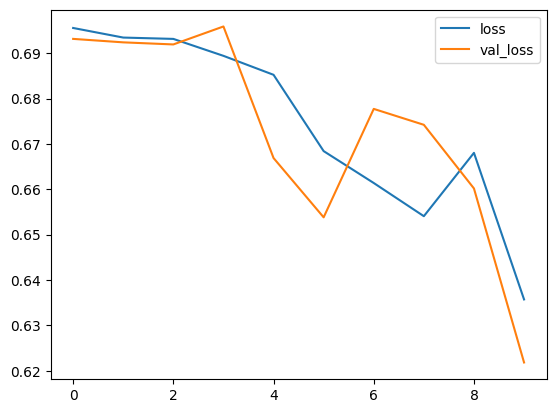

In [39]:
train_history[['loss','val_loss']].plot.line()

##Transefer Learning

In [40]:
model = tf.keras.applications.DenseNet121(
    include_top=False,

    input_shape=(244, 244, 3),

)

In [41]:
model.trainable = False
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 250, 250, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 122, 122, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 122, 122, 64)         256       ['conv1/conv[0][0]']

In [42]:
input = tf.keras.layers.Input((244, 244, 3))
x = model(input, training= False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
out = tf.keras.layers.Dense(1, 'sigmoid')(x)

model = tf.keras.Model(inputs=[input], outputs=[out])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 19883073 (75.85 MB)
Trainable params: 1284556

In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics= ['acc']
              )
model.fit(train_dataset, epochs=16, validation_data=test_dataset)

Epoch 1/16
63/63 [==============================] - 24s 213ms/step - loss: 1.9377 - acc: 0.8835 - val_loss: 0.6022 - val_acc: 0.9170
Epoch 2/16
63/63 [==============================] - 16s 184ms/step - loss: 0.5199 - acc: 0.9290 - val_loss: 0.0840 - val_acc: 0.9800
Epoch 3/16
63/63 [==============================] - 16s 187ms/step - loss: 0.1228 - acc: 0.9660 - val_loss: 0.0609 - val_acc: 0.9760
Epoch 4/16
63/63 [==============================] - 15s 184ms/step - loss: 0.0749 - acc: 0.9725 - val_loss: 0.0494 - val_acc: 0.9830
Epoch 5/16
63/63 [==============================] - 17s 193ms/step - loss: 0.0779 - acc: 0.9685 - val_loss: 0.0556 - val_acc: 0.9830
Epoch 6/16
63/63 [==============================] - 16s 192ms/step - loss: 0.0879 - acc: 0.9685 - val_loss: 0.0547 - val_acc: 0.9750
Epoch 7/16
63/63 [==============================] - 16s 183ms/step - loss: 0.0545 - acc: 0.9805 - val_loss: 0.1088 - val_acc: 0.9650
Epoch 8/16
63/63 [==============================] - 16s 195ms/step - 

In [44]:
train_history = pd.DataFrame(model.history.history)
train_history


,loss,acc,val_loss,val_acc
0,1.937735,0.8835,0.602224,0.917
1,0.519895,0.9290,0.084004,0.980
2,0.122824,0.9660,0.060942,0.976
3,0.074895,0.9725,0.049415,0.983
4,0.077934,0.9685,0.055575,0.983
5,0.087927,0.9685,0.054714,0.975
6,0.054520,0.9805,0.108817,0.965
7,0.039969,0.9885,0.076872,0.975
8,0.044839,0.9815,0.059687,0.985
9,0.038325,0.9900,0.064768,0.980


<Axes: >

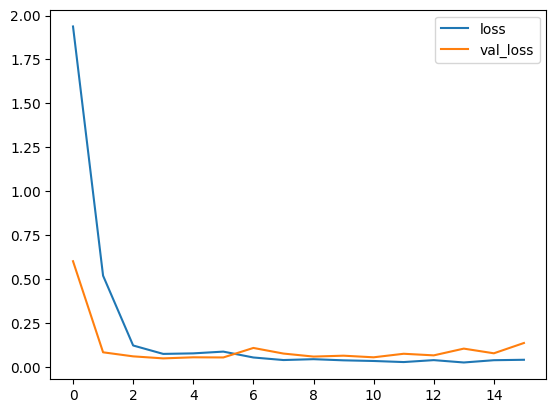

In [45]:
train_history[['loss','val_loss']].plot.line()